# import packages

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nb
from scipy import ndimage
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
# from ndmg.stats.qa_fast import qa_fast_png

In [1]:
def qa_fast_png(csf, gm, wm, outdir):
    """
    FAST (FMRIB's Automated Segmentation Tool)
    segments a 3D image of the brain into different tissue types (Grey Matter, White Matter, CSF, etc.)
    Mark different colors of white matter, gray matter, cerebrospinal fluid in a '3 by 3' picture, i.e. QA for FAST
    
    parameters
    ---------------
    csf: str
    the path of csf nifity image
    gm: str
    the path of gm nifity image
    wm: str
    the path of wm nifity image
    outdir: str
    the path to save QA graph
    
    """
    
    # load data
    gm_data = nb.load(gm).get_data()
    csf_data = nb.load(csf).get_data()
    wm_data = nb.load(wm).get_data()
    
    # set Color map
    cmap1 = LinearSegmentedColormap.from_list('mycmap1', ['white', 'blue'])
    cmap2 = LinearSegmentedColormap.from_list('mycmap2', ['white', 'magenta'])
    cmap3 = LinearSegmentedColormap.from_list('mycmap2', ['white', 'green'])
    
    
    overlay = plt.figure()
    overlay.set_size_inches(12.5, 10.5, forward=True)
    plt.title(f'Qa for FAST(segments a 3D image of the brain into different tissue types)\n (scan volume:{gm_data.shape}) \n', fontsize=22)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    
    # Determine whether the input data types are consistent. If they are inconsistent, an error is reported.
    if ((gm_data.shape != csf_data.shape) and (gm_data.shape != wm_data.shape) and (gm_data != wm_data.shape)):
        raise ValueError("Brains are not the same shape.")
    
    # Set the 3D matrix cutting position in three directions
    shape = csf_data.shape
    x = [int(shape[0] * 0.35), int(shape[0] * 0.51), int(shape[0] * 0.65)]
    y = [int(shape[1] * 0.35), int(shape[1] * 0.51), int(shape[1] * 0.65)]
    z = [int(shape[2] * 0.35), int(shape[2] * 0.51), int(shape[2] * 0.65)]
    coords = (x, y, z)
    
    # Set labels for the y-axis
    labs = [
        "Sagittal Slice",
        "Coronal Slice",
        "Axial Slice",
    ]
    
    
    var = ["X", "Y", "Z"]
    
    # Generate 3 by 3 picture
    idx = 0
    for i, coord in enumerate(coords):
        for pos in coord:
            idx += 1
            ax = overlay.add_subplot(3, 3, idx)
            ax.set_title(var[i] + " = " + str(pos))
            if i == 0:
                csf_slice = ndimage.rotate(csf_data[pos, :, :], 90)
                gm_slice = ndimage.rotate(gm_data[pos, :, :], 90)
                wm_slice = ndimage.rotate(wm_data[pos, :, :], 90)
            elif i == 1:
                csf_slice = ndimage.rotate(csf_data[:, pos, :], 90)
                gm_slice = ndimage.rotate(gm_data[:, pos, :], 90)
                wm_slice = ndimage.rotate(wm_data[:, pos, :], 90)
            else:
                csf_slice = ndimage.rotate(csf_data[:, :, pos], 90)
                gm_slice = ndimage.rotate(gm_data[:, :, pos], 90)
                wm_slice = ndimage.rotate(wm_data[:, :, pos], 90)
                
            if idx % 3 == 1:
                plt.ylabel(labs[i])
            
            #  padding pictures to make them the same size
            csf_slice = (csf_slice*255).astype(np.uint8)
            gm_slice = (gm_slice*255).astype(np.uint8)
            wm_slice = (wm_slice*255).astype(np.uint8)
            csf_slice = pad_im(csf_slice, max(shape), 0, False)
            gm_slice = pad_im(gm_slice, max(shape), 0, False)
            wm_slice = pad_im(wm_slice, max(shape), 0, False)
            
            # Hide axes
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            
            # display image
            ax.imshow(csf_slice, interpolation="none", cmap=cmap1, alpha=1)
            ax.imshow(gm_slice, interpolation="none", cmap=cmap2, alpha=0.5)
            ax.imshow(wm_slice, interpolation="none", cmap=cmap3, alpha=0.3)
           
            # Legend of white matter(WM), gray matter(GM) and cerebrospinal fluid(csf)
            if idx == 3:
                plt.plot(0, 0, "-", c='green', label='wm')
                plt.plot(0, 0, "-", c='pink', label='gm')
                plt.plot(0, 0, "-", c='blue', label='csf')
                plt.legend(loc='upper right',fontsize=15,bbox_to_anchor=(1.5,1.5))
                
    # save figure
    overlay.savefig(f"{outdir}", format="png")

In [6]:
def pad_im(image,max_dim,pad_val,rgb):
    """
    Pads an image to be same dimensions as given max_dim
    
    Parameters
    -----------
    image: np array
        image object can be multiple dimensional or a slice.
    max_dim: int
        dimension to pad up to
    pad_val: int
        value to pad with. 
    rgb: boolean
        flag to indicate if RGB and last dimension should not be padded
    Returns
    -----------
    padded_image: np array
        image with padding
    """
    pad_width = []
    for i in range(image.ndim):
        pad_width.append(((max_dim-image.shape[i])//2,(max_dim-image.shape[i])//2))
    if rgb:
        pad_width[-1] = (0,0)

    #convert to tuple
    pad_width = tuple(pad_width)
    padded_image = np.pad(image, pad_width=pad_width, mode='constant', constant_values=pad_val)
    
    return padded_image

# set the input data path

In [7]:
# change this path when you want to run in you own computer
output_dir = 'd:/Downloads/neurodatadesign/output_data/flirt/sub-0025864/ses-1/'

# the path setting
csf_input = f"{output_dir}anat/preproc/t1w_seg_pve_0.nii.gz"
gm_input = f"{output_dir}anat/preproc/t1w_seg_pve_1.nii.gz"
wm_input = f"{output_dir}anat/preproc/t1w_seg_pve_2.nii.gz"
save_dir = f"{output_dir}qa/reg/qa_fast.png"

# Call function to generate quality analysis picture

NameError: name 'pad_im' is not defined

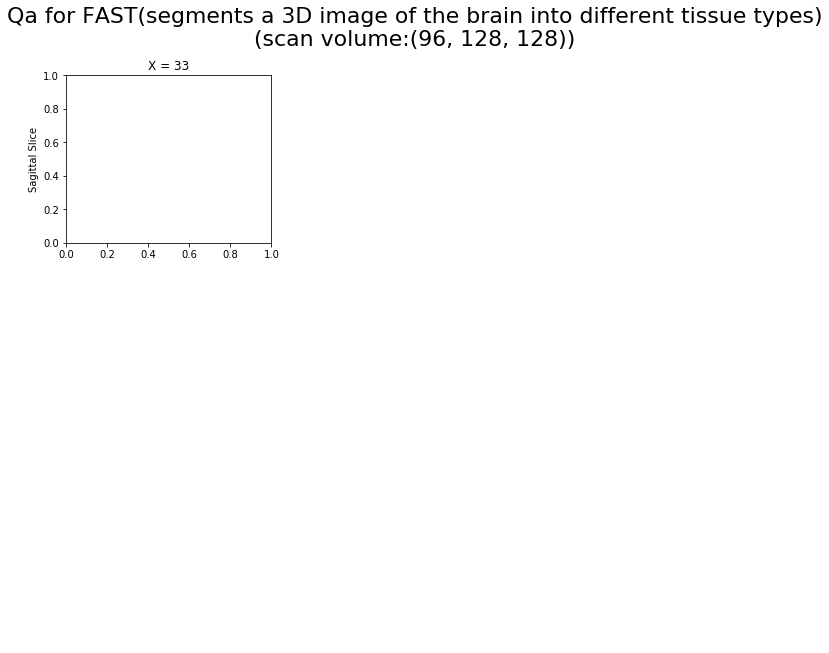

In [5]:
# Generates quality analysis pictures of white matter, gray matter and cerebrospinal fluid
qa_fast_png(csf_input, gm_input, wm_input, save_dir)